In [1]:
import matplotlib.pyplot as plt
import numpy as np # useful for calculations
import h5py #required to read hdf5 files
import matplotlib as mpl
from tqdm import tqdm
from scipy import spatial
import pdb


FloatType = np.float64  # double precision: np.float64, for single use np.float32

def read_gadget_snapshot(file_name):
	data = h5py.File(file_name, 'r')  # load full hdf5 file

	time = FloatType(data['Header'].attrs['Time']) # the scale factor at which snapshot was written
	BoxSize = FloatType(data['Header'].attrs['BoxSize']) # box size in code units (Mpc)

	Pos = np.array(data['PartType1']['Coordinates'], dtype=FloatType) #3d Positions of all particles, e.g. x coord: Pos[:,0]

	mass = FloatType(data['Header'].attrs['MassTable'][1]) # mass of one DM particle

	n_particles = Pos.size // 3

	return time, Pos, mass, n_particles, BoxSize


file_name = "snapshot_002.hdf5"

time, Pos, mass, n_particles, BoxSize = read_gadget_snapshot(file_name)

print("Scale factor: %g  (should be 1)" %(time))

box_vol = BoxSize**3
mean_dist = (box_vol/n_particles)**(1/3)
print('mean distance between particles = {}'.format(mean_dist))


Scale factor: 1  (should be 1)
mean distance between particles = 0.3125


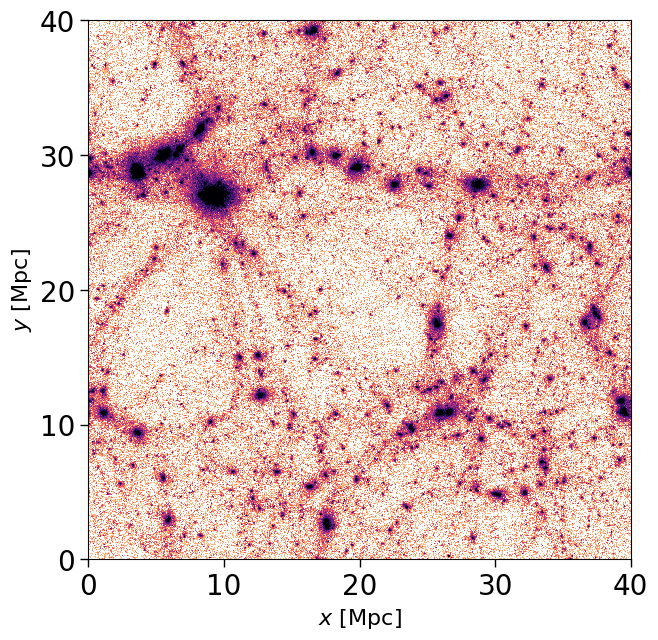

In [2]:
x=Pos[:, 0]
y=Pos[:, 1]
z=Pos[:, 2]

plt.rc('font', family='sans')
plt.rcParams.update({
    'agg.path.chunksize': 2000,
    'xtick.direction': 'out',
    'xtick.major.size': 6,
    'xtick.major.width': 1,
    'xtick.minor.size': 3,
    'xtick.minor.width': 0.8,
    'xtick.minor.visible': False,
    'ytick.direction': 'out',
    'ytick.major.size': 6,
    'ytick.major.width': 1,
    'ytick.minor.size': 3,
    'ytick.minor.width': 0.8,
    'ytick.minor.visible': False,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.top': False,
    'ytick.right': False,
})

plt.figure(figsize=(7,7))
plt.hist2d(x, y, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap = 'magma_r') 
plt.xlabel('$x$ [Mpc]')
plt.ylabel('$y$ [Mpc]')
# plt.colorbar()
plt.xticks([0,10,20,30,40])
plt.yticks([0,10,20,30,40])
# plt.savefig('figures/structure_map.png', dpi=200, transparent=True)
plt.show()

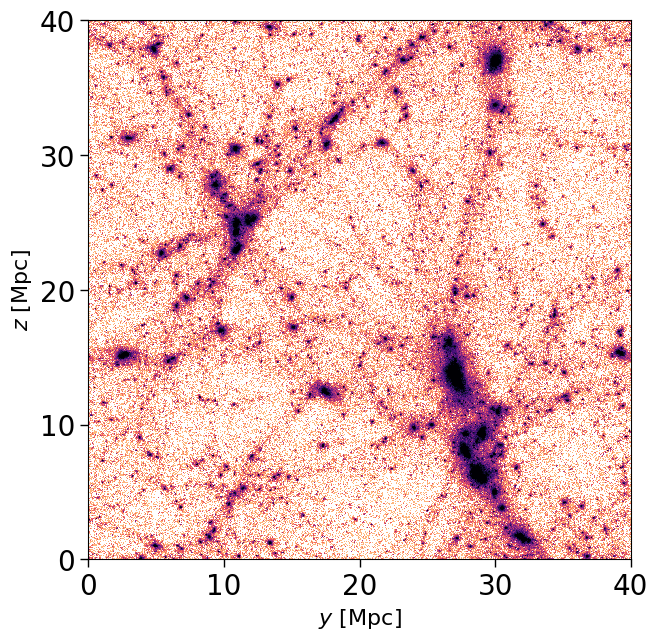

In [34]:
plt.figure(figsize=(7,7))
plt.hist2d(y, z, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap = 'magma_r') 
plt.xlabel('$y$ [Mpc]')
plt.ylabel('$z$ [Mpc]')
# plt.colorbar()
plt.xticks([0,10,20,30,40])
plt.yticks([0,10,20,30,40])
# plt.savefig('figures/structure_map.png', dpi=200, transparent=True)
plt.show()

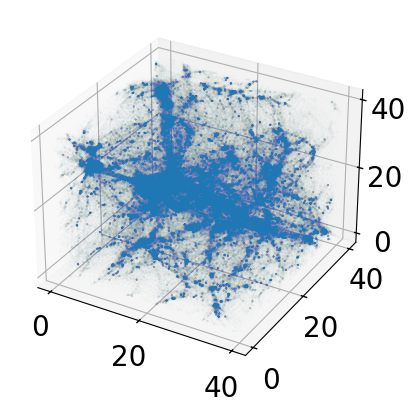

In [49]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x,y,z, s=0.1, alpha=0.01)
plt.show()

In [ ]:
def particle_distance(i, j, positions):
    x_i, y_i, z_i = positions[i, 0], positions[i, 1], positions[i, 2]
    x_j, y_j, z_j = positions[j, 0], positions[j, 1], positions[j, 2]
    return np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2 + (z_i - z_j)**2)

In [3]:
# friends of friends algorithm

# linking length:
linking_length = mean_dist*0.2
print('mean distance:', mean_dist, 'Mpc')
print('linking_length = ', linking_length)

# find friends:
all_particles = np.linspace(0, n_particles - 1, n_particles)
# all_particles = np.linspace(0, 9, 10)
lonely = all_particles
num_groups = 0
friend_dict = {}

for i in range(n_particles):  # Generates numbers from 0 to 10
    friend_dict[i] = []

# for i in tqdm(range(n_particles)):
#     print('on particle {}'.format(i))
#     # for j in tqdm(range(len(lonely))):
#     for j in range(i+1, n_particles): # vb changed to look at the upper triangle in the nxn particle matrix since it's symmetric ij vs ji, removed 2nd tqdm since would print 2 million times for each i

#         dist = particle_distance(i, j, Pos)
#         # print('potential neighbors {}'.format(j))
#         # print(dist)
#         # check if the particles are friends
#         if dist < linking_length:
#             friend_dict[i].append(j)
#             friend_dict[j].append(i)
#             # print('particle {} and {} are friends'.format(i, j))
#         else:
#             # particles are not friends
#             continue

mean distance: 0.3125 Mpc
linking_length =  0.0625


In [4]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query_pairs.html
tree = spatial.cKDTree(Pos)
pairs = tree.query_pairs(r=linking_length, output_type='ndarray') # unique pairs of all points within linking length of one another

In [5]:
# for i, j in friend_pairs:
#     friend_dict[i].append(j)
#     friend_dict[j].append(i)

# chatgpt did this because appending particle by particle was taking an inconceivable amount of time

src = np.r_[pairs[:,0], pairs[:,1]]
dst = np.r_[pairs[:,1], pairs[:,0]]
order = np.argsort(src)
src = src[order]; dst = dst[order]
friends = np.split(dst, np.cumsum(np.bincount(src, minlength=n_particles))[:-1])


In [7]:
"""
general idea:
    choose a particle that hasn't been checked yet
    assign a new halo to it
    make a list of new particles to check - initially the list of that particle's friends
    for each particle in the to_check list, 
    see if it's been checked, and if not, add it to the halo, and add its friends to the to_check list
    continue until there are no particles left to check
    if there is 
    then find a new lonely particle and do the same thing
"""


checked = np.zeros(n_particles, dtype=bool)

halos = []
for i in tqdm(range(n_particles)):
    if not checked[i]: # find a particle that hasn't been checked yet 
        checked[i] = True
        halo = [i] # assign a halo to it
        to_check = list(friends[i]) # initialize a list of other particles to check / add to the halo
        while len(to_check)>0:
            particle = to_check.pop() # gets the index but removes that index from the list of particles to check
            if not checked[particle]:
                checked[particle] = True # mark that we've checked the particle
                halo.append(particle) # add prticle to halo
                to_check.extend(friends[particle]) # add its friends to the list of particles to check
        if len(halo) > 1:
            halos.append(halo)

100%|██████████| 2097152/2097152 [00:51<00:00, 40740.42it/s] 


In [62]:
sizes = np.array([len(h) for h in halos])

## 3rd most massive halo

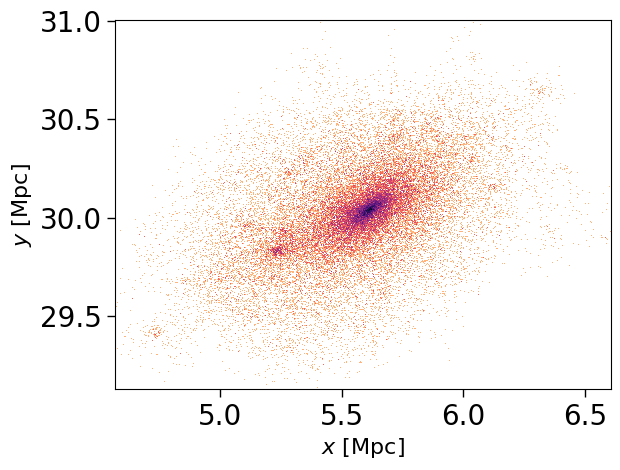

In [ ]:
halo3 = halos[2]
n_halo3 = len(halo3)

Pos3 = Pos[halo3]


x3=Pos3[:, 0]
y3=Pos3[:, 1]
z3=Pos3[:, 2]
plt.hist2d(x3, y3, bins = 500,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap = 'magma_r') 
plt.xlabel('$x$ [Mpc]')
plt.ylabel('$y$ [Mpc]')
# plt.savefig('3rd_largest_halo_map.png', dpi=200, transparent=True)


## Radial density profile
3rd largest halo at z=0 --> since all particles same mass, just find the one with the greatest number of particles

[[ 6.41114998 30.3267765  36.7232666 ]
 [ 6.42100096 30.26623344 36.72865295]
 [ 6.39970446 30.26931572 36.77457809]
 ...
 [ 5.12494802 30.3495903  36.63881683]
 [ 5.59025478 29.48130035 36.99419022]
 [ 6.30980778 30.28481102 36.7494278 ]]
(25007.688957773105, 1.432987567130095)


Text(0, 0.5, 'log(N)')

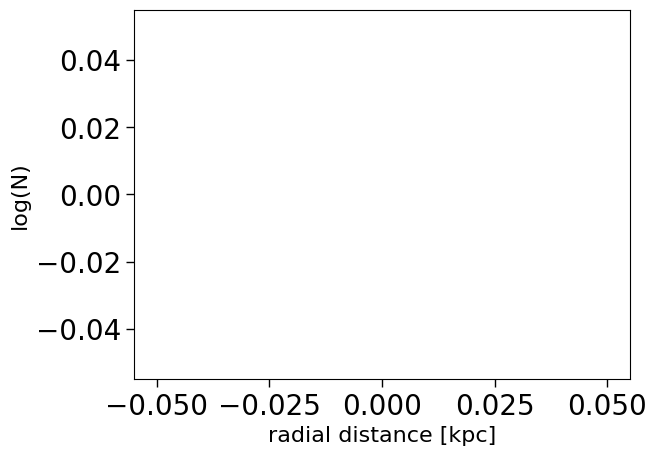

In [67]:
from photutils.profiles import RadialProfile
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from scipy.ndimage import center_of_mass

print(Pos3)

center = center_of_mass(Pos3)
print(center)

rp = RadialProfile(Pos3, center, radii=np.arange(100))
rad_mpc = rp.radius
rad_kpc = rad_mpc*1000
prof = rp.profile
prof_log = np.log10(prof)
plt.plot(rad_mpc, prof_log, color="#095e88")
plt.xlabel('radial distance [kpc]' )
plt.ylabel('log(N)') # TODO change to something more intuitive


(array([3480.,  189.,   63.,   34.,   25.,   15.,    9.,   16.,    8.]),
 array([  20.,  240.,  460.,  680.,  900., 1120., 1340., 1560., 1780.,
        2000.]),
 <BarContainer object of 9 artists>)

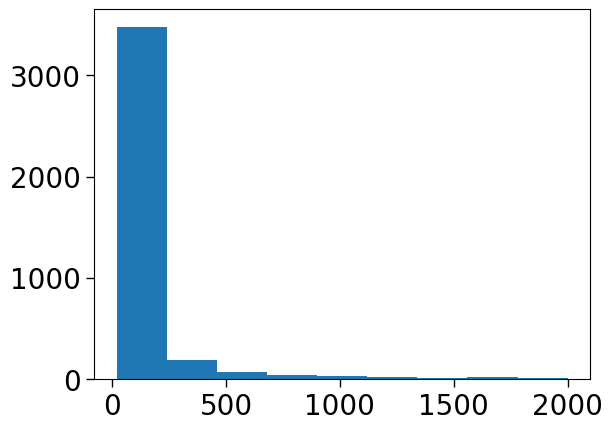

In [61]:
mask = sizes >= 20
plt.hist(sizes[mask], bins=np.linspace(20, 2000, 10))